In [4]:
#1000 명의 에세이 분석 평균값 계산하기, 이것을 web의 ai_plot_conflict.py에 적용해야 함

#conflict
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
import pandas as pd
from pandas import DataFrame as df
from mpld3 import plugins, fig_to_html, save_html, fig_to_dict
from tqdm import tqdm
import numpy as np
import json
from tensorflow.keras.preprocessing.text import text_to_word_sequence

#character, setting
import numpy as np
import gensim
import nltk
import re
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
from nltk.tokenize import sent_tokenize
import multiprocessing
import os
from pathlib import Path
import io
from gensim.models import Phrases
from textblob import TextBlob
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from collections import defaultdict



def ai_plot_conf(essay_input_):
    #1.input essay
    input_text = essay_input_

    #########################################################################

    #2.유사단어를 추출하여 리스트로 반환
    def conflict_sim_words(text):

        essay_input_corpus = str(text) #문장입력
        essay_input_corpus = essay_input_corpus.lower()#소문자 변환

        sentences  = sent_tokenize(essay_input_corpus) #문장 토큰화
        total_sentences = len(sentences)#토큰으로 처리된 총 문장 수
        total_words = len(word_tokenize(essay_input_corpus))# 총 단어수
        
        split_sentences = []
        for sentence in sentences:
            processed = re.sub("[^a-zA-Z]"," ", sentence)
            words = processed.split()
            split_sentences.append(words)

        skip_gram = 1
        workers = multiprocessing.cpu_count()
        bigram_transformer = Phrases(split_sentences)

        model = gensim.models.word2vec.Word2Vec(bigram_transformer[split_sentences], workers=workers, sg=skip_gram, min_count=1)

        model.train(split_sentences, total_examples=sum([len(sentence) for sentence in sentences]), epochs=100)
        
        #모델 설계 완료

        #표현하는 단어들을 리스트에 넣어서 필터로 만들고
        confict_words_list = ['clash', 'incompatible', 'inconsistent', 'incongruous', 'opposition', 'variance','vary', 'odds', 
                                'differ', 'diverge', 'disagree', 'contrast', 'collide', 'contradictory', 'incompatible', 'conflict',
                                'inconsistent','irreconcilable','incongruous','contrary','opposite','opposing','opposed',
                                'antithetical','clashing','discordant','differing','different','divergent','discrepant',
                                'varying','disagreeing','contrasting','at odds','in opposition','at variance' ]
        
        ####문장에 list의 단어들이 있는지 확인하고, 있다면 유사단어를 추출한다.
        
        #우선 토큰화한다.
        retokenize = RegexpTokenizer("[\w]+") #줄바꿈 제거하여 한줄로 만들고
        token_input_text = retokenize.tokenize(essay_input_corpus)
        #print (token_input_text) #토큰화 처리 확인.. 토큰들이 리스트에 담김
        #리트스로 정리된 개별 토큰을 char_list와 비교해서 존재하는 것만 추출한다.
        filtered_chr_text = []
        for k in token_input_text:
            for j in confict_words_list:
                if k == j:
                    filtered_chr_text.append(j)
        
        #print (filtered_chr_text) # 유사단어 비교 추출 완료, 겹치는 단어는 제거하자.
        
        filtered_chr_text_ = set(filtered_chr_text) #중복제거
        filtered_chr_text__ = list(filtered_chr_text_) #다시 리스트로 변환
        #print (filtered_chr_text__) # 중복값 제거 확인
        
#         for i in filtered_chr_text__:
#             ext_sim_words_key = model.most_similar_cosmul(i) #모델적용
        
#         char_total_count = len(filtered_chr_text) # 중복이 제거되지 않은 에세이 총 문장에 사용된 표현 수
#         char_count_ = len(filtered_chr_text__) #중복제거된  표현 총 수
            
#         result_char_ratio = round(char_total_count/total_words * 100, 2)

#         import pandas as pd

#         df_conf_words = pd.DataFrame(ext_sim_words_key, columns=['words','values']) #데이터프레임으로 변환
#         df_r = df_conf_words['words'] #words 컬럼 값 추출
#         ext_sim_words_key = df_r.values.tolist() # 유사단어 추출
        ext_sim_words_key = filtered_chr_text__

        #return result_char_ratio, total_sentences, total_words, char_total_count, char_count_, ext_sim_words_key
        return ext_sim_words_key



    #########################################################################
    # 3.유사단어를 문장에서 추출하여 반환한다.
    conflict_sim_words_ratio_result = conflict_sim_words(input_text)



    #########################################################################
    # 4.CONFLICT GRAPH EXPRESSION Analysis  -- 그래프로 그리기
    # conflict(input_text):
    contents = str(input_text)
    token_list_str = text_to_word_sequence(contents) #tokenize

    confict_words_list_basic = ['clash', 'incompatible', 'inconsistent', 'incongruous', 'opposition', 'variance','vary', 'odds', 
                            'differ', 'diverge', 'disagree', 'contrast', 'collide', 'contradictory', 'incompatible', 'conflict',
                            'inconsistent','irreconcilable','incongruous','contrary','opposite','opposing','opposed',
                            'antithetical','clashing','discordant','differing','different','divergent','discrepant',
                            'varying','disagreeing','contrasting','at odds','in opposition','at variance' ]

    confict_words_list = confict_words_list_basic + conflict_sim_words_ratio_result #유사단어를 계산결과 반영!

    count_conflict_list = []
    for i in token_list_str:
        for j in confict_words_list:
            if i == j:
                count_conflict_list.append(j)

    len(count_conflict_list) # 한 문장에 들어있는 conflict 단어 수

    list_str = contents.split(".")  # 문장별로 분리한다. 분리는 .를 기준으로 한다.   

    listSentiment = []

    sid = SentimentIntensityAnalyzer()

    i=0
    for sentence in tqdm(list_str): #한문장식 가져와서 처리한다.
        ss = sid.polarity_scores(sentence) #긍정, 부정, 중립, 혼합점수 계산
        #print(ss.keys())
        #print('{}: neg:{},neu:{},pos:{},compound:{}'.format(i,ss['neg'],ss['neu'],ss['pos'],ss['compound']))
        #print('{}: neg:{}'.format(i,ss['neg']))
        i +=1
        listSentiment.append([ss['neg'],ss['neu'],ss['pos'],ss['compound']])

    import pandas as pd

    df_sent = pd.DataFrame(listSentiment)
    df_sent.columns = ['neg', 'neu', 'pos','compound']
    reslult_df = df_sent.columns


    df_sent['comp_score'] = df_sent['compound'].apply(lambda c: 'pos' if c >=0  else 'neg')

    df_sent['comp_score'].value_counts()

    conflict_ratio = df_sent['comp_score'].value_counts(normalize=True) #상대적 비율 계산

    # df_sent 의 값은 아래와 같다.

    # neg	neu	pos	compound	comp_score
    # 0	0.000	0.808	0.192	0.2280	pos
    # 1	0.000	1.000	0.000	0.0000	pos
    # 2	0.041	0.778	0.181	0.7269	pos
    # 3	0.044	0.787	0.169	0.6486	pos
    # 4	0.190	0.678	0.132	-0.2144	neg
    # 5	0.000	1.000	0.000	0.0000	pos

    #comp_score를 1 -1 변환
    df_sent.loc[df_sent["comp_score"] == "pos","comp_score"] = 1
    df_sent.loc[df_sent["comp_score"] == "neg","comp_score"] = -1

    # df_sent 의 변환된 값은 아래와 같다.
    # neg	neu	pos	compound	comp_score
    # 0	0.000	0.808	0.192	0.2280	1
    # 1	0.000	1.000	0.000	0.0000	1
    # 2	0.041	0.778	0.181	0.7269	1
    # 3	0.044	0.787	0.169	0.6486	1
    # 4	0.190	0.678	0.132	-0.2144	-1
    # 5	0.000	1.000	0.000	0.0000	

    #########################################################################
    # 5. 그래프로 그려보자. 이 코드는 matplotlib 로 그린것임. 종필은 highcharts로 표현할 것
    #########################################################################
    
    # from matplotlib import pyplot as plt

    # plt.plot(df_sent)
    # plt.xlabel('STORY')
    # plt.ylabel('CONFLICT')
    # plt.title('FLOW ANALYSIS')
    # plt.legend(['neg','neu','pos','compound','reslult'])
    # plt.show()

    #########################################################################
    # 6.ACTION VERB로 그래프 그리기


    #입력한 글을 모두 단어로 쪼개로 리스트로 만들기 - 
    essay_input_corpus_ = str(input_text) #문장입력
    essay_input_corpus_ = essay_input_corpus_.lower()#소문자 변환

    sentences_  = sent_tokenize(essay_input_corpus_) #문장단위로 토큰화(구분)되어 리스에 담김

    # 문장을 토크큰화하여 해당 문장에 Action Verbs가 있는지 분석 부분 코드임 ---> 뒤에서 나옴 아래 777로 표시된 코드부분에서 sentences_ 값 재활용

    split_sentences_ = []
    for sentence in sentences_:
        processed = re.sub("[^a-zA-Z]"," ", sentence)
        words = processed.split()
        split_sentences_.append(words)
        
    # 입력한 문장을 모두 리스트로 변환
    input_text_list = [y for x in split_sentences_ for y in x] # 이중 리스트 Flatten

    #리스로 변환된 값 확인
    #input_text_list 

    #csv 파일에서 Action Verbs 단어 사전 불러오기
    import pandas as pd

    #Awards 데이터 불러오기
    data_action_verbs = pd.read_csv('actionverbs.csv')
    data_ac_verbs_list = data_action_verbs.values.tolist()
    verbs_list = [y for x in data_ac_verbs_list for y in x]

    #########################################################################
    # 7.Action Verbs 유사단어를 추출하여 리스트로 반환

    def actionverb_sim_words(text):

        essay_input_corpus = str(text) #문장입력
        essay_input_corpus = essay_input_corpus.lower()#소문자 변환

        sentences  = sent_tokenize(essay_input_corpus) #문장 토큰화
        total_sentences = len(sentences)#토큰으로 처리된 총 문장 수
        total_words = len(word_tokenize(essay_input_corpus))# 총 단어수
        
        split_sentences = []
        for sentence in sentences:
            processed = re.sub("[^a-zA-Z]"," ", sentence)
            words = processed.split()
            split_sentences.append(words)

        skip_gram = 1
        workers = multiprocessing.cpu_count()
        bigram_transformer = Phrases(split_sentences)

        model = gensim.models.word2vec.Word2Vec(bigram_transformer[split_sentences], workers=workers, sg=skip_gram, min_count=1)

        model.train(split_sentences, total_examples=sum([len(sentence) for sentence in sentences]), epochs=100)
        
        #모델 설계 완료

        # ACTION VERBS 표현하는 단어들을 리스트에 넣어서 필터로 만들고
        ##################################################
        # verbs_list

        ####문장에 list의 단어들이 있는지 확인하고, 있다면 유사단어를 추출한다.
        
        #우선 토큰화한다.
        retokenize = RegexpTokenizer("[\w]+") #줄바꿈 제거하여 한줄로 만들고
        token_input_text = retokenize.tokenize(essay_input_corpus)
        #print (token_input_text) #토큰화 처리 확인.. 토큰들이 리스트에 담김
        #리트스로 정리된 개별 토큰을 char_list와 비교해서 존재하는 것만 추출한다.
        filtered_chr_text = []
        for k in token_input_text:
            for j in verbs_list:
                if k == j:
                    filtered_chr_text.append(j)
        
        #print (filtered_chr_text) # 유사단어 비교 추출 완료, 겹치는 단어는 제거하자.
        
        filtered_chr_text_ = set(filtered_chr_text) #중복제거
        filtered_chr_text__ = list(filtered_chr_text_) #다시 리스트로 변환
        #print (filtered_chr_text__) # 중복값 제거 확인
        
#         for i in filtered_chr_text__:
#             ext_sim_words_key = model.most_similar_cosmul(i) #모델적용
        
#         char_total_count = len(filtered_chr_text) # 중복이 제거되지 않은 에세이 총 문장에 사용된 표현 수
#         char_count_ = len(filtered_chr_text__) #중복제거된  표현 총 수
            
#         result_char_ratio = round(char_total_count/total_words * 100, 2)
        
#         df_conf_words = pd.DataFrame(ext_sim_words_key, columns=['words','values']) #데이터프레임으로 변환
#         df_r = df_conf_words['words'] #words 컬럼 값 추출
#         ext_sim_words_key = df_r.values.tolist() # 유사단어 추출

        #return result_char_ratio, total_sentences, total_words, char_total_count, char_count_, ext_sim_words_key
        ext_sim_words_key = filtered_chr_text__
        return ext_sim_words_key


    # 입력문장에서 맥락상 Aciton Verbs와 유사한 의미의 단어를 추출
    ext_action_verbs = actionverb_sim_words(input_text)

    #########################################################################
    # 8.이제 입력문장에서 사용용된 Action Verbs 단어를 비교하여 추출해보자.

    # Action Verbs를 모두 모음(직접적인 단어, 문맥상 유사어 포함)
    all_ac_verbs_list = verbs_list + ext_action_verbs

    #입력한 수생내역의 리스트 값을 하나씩 불러와서 데이터프레이에 있는지 비교 찾아내서 해당 점수를 가져오기
    graph_calculation_list = []
    get_words__ = []
    for each_verb in all_ac_verbs_list: #데이터프레임에서 인덱스의 값과 비교하여
        for h in input_text_list: #df에 특정 단어가 있다면, 해당하는 컬럼의 값을 가져오기
            if each_verb == h:
                get_words__.append(h) # 동일하면 저장하기
                graph_calculation_list.append(1)
            
        else: #없다면
            graph_calculation_list.append(0)

    #문장에 Action Verbs 추출확인
    #get_words__ 

    #########################################################################
    # 9. 그래프 출력 : 문장 전체를 단어로 분리하고, Action verbs가 사용된 부분을 그래프로 표시

    # 전체 글에서 Action verbs가 언급된 부분을 리스트로 계산(있다 : 1, 없다: 0)
    # graph_calculation_list 

    #그래프로 표시됨
    plt.plot(graph_calculation_list)
    plt.xlabel('STORY')
    plt.ylabel('ACTON VERBS')
    plt.title('USAGE OF ACTION VERBS ANALYSIS')
    plt.legend(['action verbs'])
    plt.show()

    #########################################################################
    # 10.입력한 에세이 문장에서 Action Verbs가 얼마나 포함되어 있는지 포함비율 분석
    action_verbs_ratio = round(len(get_words__)/len(input_text_list) *100, 3)

    print ("ACTION VERBS RATIO :", action_verbs_ratio )


    #########################################################################
    # 11. 글속에 감정이 얼마나 표현되어 있는지 분석 - origin (Bert pre trained model 활용)
    from transformers import BertTokenizer
    from model import BertForMultiLabelClassification
    from multilabel_pipeline import MultiLabelPipeline
    from pprint import pprint


    tokenizer = BertTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original")
    model = BertForMultiLabelClassification.from_pretrained("monologg/bert-base-cased-goemotions-original")

    goemotions = MultiLabelPipeline(
        model=model,
        tokenizer=tokenizer,
        threshold=0.3
    )
    #결과확인
    #print(goemotions(texts))
    ########## 여기서는 최초 입력 에세이를 적용한다. input_text !!!!!!!!
    re_text = input_text.split(".")

    #데이터 전처리 
    def cleaning(datas):

        fin_datas = []

        for data in datas:
            # 영문자 이외 문자는 공백으로 변환
            only_english = re.sub('[^a-zA-Z]', ' ', data)
        
            # 데이터를 리스트에 추가 
            fin_datas.append(only_english)

        return fin_datas

    texts = cleaning(re_text)

    #분석된 감정만 추출
    emo_re = goemotions(texts)

    emo_all = []
    for list_val in range(0, len(emo_re)):
        #print(emo_re[list_val]['labels'],emo_re[list_val]['scores'])
        #mo_all.append((emo_re[list_val]['labels'],emo_re[list_val]['scores'])) #KEY, VALUE만 추출하여 리스트로 저장
        #emo_all.append(emo_re[list_val]['scores'])
        emo_all.append((emo_re[list_val]['labels']))
        
    #추출결과 확인 
    # emo_all

    # ['sadness'],
    #  ['anger'],
    #  ['admiration', 'realization'],
    #  ['admiration', 'disappointment'],
    #  ['love'],
    #  ['sadness', 'neutral'],
    #  ['realization', 'neutral'],
    #  ['neutral'],
    #  ['optimism'],
    #  ['neutral'],
    #  ['excitement'],
    #  ['neutral'],
    #  ['neutral'],
    #  ['caring'],
    #  ['gratitude'],
    #  ['admiration', 'approval'], ...

    from pandas.core.common import flatten #이중리스틀 FLATTEN하게 변환
    flat_list = list(flatten(emo_all))

    # ['neutral',
    #  'neutral',
    #  'sadness',
    #  'anger',
    #  'admiration',
    #  'realization',
    #  'admiration',
    #  'disappointment',


    #중립적인 감정을 제외하고, 입력한 문장에서 다양한 감정을 모두 추출하고 어떤 감정이 있는지 계산해보자
    unique = []
    for r in flat_list:
        if r == 'neutral':
            pass
        else:
            unique.append(r)

    #중립감정 제거 및 유일한 감정값 확인
    #unique
    unique_re = set(unique) #중복제거

    ############################################################################
    # 글에 표현된 감정이 얼마나 다양한지 분석 결과!!!¶
    print("====================================================================")
    print("에세이에 표현된 다양한 감정 수:", len(unique_re))
    print("====================================================================")

    #분석가능한 감정 총 감정 수 - Bert origin model 적용시 28개 감정 추출돰
    total_num_emotion_analyzed = 28

    # 감정기복 비율 계산 !!!
    result_emo_swings =round(len(unique_re)/total_num_emotion_analyzed *100,1) #소숫점 첫째자리만 표현
    result_emo_swings
    print("문장에 표현된 감정 비율 : ", result_emo_swings)
    print("====================================================================")


    #########################################################################
    # 12. SETTING RATIO 계산

    def setting_anaysis(text):

        essay_input_corpus = str(text) #문장입력
        essay_input_corpus = essay_input_corpus.lower()#소문자 변환

        sentences  = sent_tokenize(essay_input_corpus) #문장 토큰화
        total_sentences = len(sentences)#토큰으로 처리된 총 문장 수
        total_words = len(word_tokenize(essay_input_corpus))# 총 단어수
        split_sentences = []
        for sentence in sentences:
            processed = re.sub("[^a-zA-Z]"," ", sentence)
            words = processed.split()
            split_sentences.append(words)

        skip_gram = 1
        workers = multiprocessing.cpu_count()
        bigram_transformer = Phrases(split_sentences)

        model = gensim.models.word2vec.Word2Vec(bigram_transformer[split_sentences], workers=workers, sg=skip_gram, min_count=1)

        model.train(split_sentences, total_examples=sum([len(sentence) for sentence in sentences]), epochs=100)
        
        #모델 설계 완료

        #setting을 표현하는 단어들을 리스트에 넣어서 필터로 만들고
        location_list = ['above', 'behind','below','beside','betweed','by','in','inside','near',
                        'on','over','through']
        time_list = ['after', 'before','by','during','from','on','past','since','through','to','until','upon']
        
        movement_list = ['against','along','down','from','into','off','on','onto','out of','toward','up','upon']
        
        palce_terrain_type_list = ['wood', 'forest', 'copse', 'bush', 'trees', 'stand',
                                    'swamp', 'marsh', 'wetland', 'fen', 'bog', 'moor', 'heath', 'fells', 'morass',
                                    'jungle', 'rainforest', 'cloud forest','plains', 'fields', 'grass', 'grassland', 
                                    'savannah', 'flood plain', 'flats', 'prairie','tundra', 'iceberg', 'glacier', 
                                    'snowfields','hills', 'highland,' 'heights', 'plateau', 'badland', 'kame', 'shield',
                                    'downs', 'downland', 'ridge', 'ridgeline','hollow,' 'valley',' vale','glen', 'dell',
                                    'mountain', 'peak', 'summit', 'rise', 'pass', 'notch', 'crown', 'mount', 'switchback',
                                    'furth','canyon', 'cliff', 'bluff,' 'ravine', 'gully', 'gulch', 'gorge',
                                    'desert', 'scrub', 'waste', 'wasteland', 'sands', 'dunes',
                                    'volcano', 'crater', 'cone', 'geyser', 'lava fields']
        
        water_list = ['ocean', 'sea', 'coast', 'beach', 'shore', 'strand','bay', 'port', 'harbour', 'fjord', 'vike',
                    'cove', 'shoals', 'lagoon', 'firth', 'bight', 'sound', 'strait', 'gulf', 'inlet', 'loch', 
                    'bayou','dock', 'pier', 'anchorage', 'jetty', 'wharf', 'marina', 'landing', 'mooring', 'berth', 
                    'quay', 'staith','river', 'stream', 'creek', 'brook', 'waterway', 'rill','delta', 'bank', 'runoff',
                    'bend', 'meander', 'backwater','lake', 'pool', 'pond', 'dugout', 'fountain', 'spring', 
                    'watering-hole', 'oasis','well', 'cistern', 'reservoir','waterfall', 'falls', 'rapids', 'cataract', 
                    'cascade','bridge', 'crossing', 'causeway', 'viaduct', 'aquaduct', 'ford', 'ferry','dam', 'dike', 
                    'bar', 'canal', 'ditch','peninsula', 'isthmus', 'island', 'isle', 'sandbar', 'reef', 'atoll', 
                    'archipelago', 'cay','shipwreck', 'derelict']
        
        
        outdoor_places_list = ['clearing', 'meadow', 'grove', 'glade', 'fairy ring','earldom', 'fief', 'shire',
                                'ruin', 'acropolis', 'desolation', 'remnant', 'remains',
                                'henge', 'cairn', 'circle', 'mound', 'barrow', 'earthworks', 'petroglyphs',
                                'lookout', 'aerie', 'promontory', 'outcropping', 'ledge', 'overhang', 'mesa', 'butte',
                                'outland', 'outback', 'territory', 'reaches', 'wild', 'wilderness', 'expanse',
                                'view', 'vista', 'tableau', 'spectacle', 'landscape', 'seascape', 'aurora', 'landmark',
                                'battlefield', 'trenches', 'gambit', 'folly', 'conquest', 'claim', 'muster', 'post',
                                'path', 'road', 'track', 'route', 'highway', 'way', 'trail', 'lane', 'thoroughfare', 'pike',
                                'alley', 'street', 'avenue', 'boulevard', 'promenade', 'esplande', 'boardwalk',
                                'crossroad', 'junction', 'intersection', 'turn', 'corner','plaza', 'terrace', 'square', 
                                'courtyard', 'court', 'park', 'marketplace', 'bazaar', 'fairground','realm', 'land', 'country',
                                'nation', 'state', 'protectorate', 'empire', 'kingdom', 'principality','domain', 'dominion',
                                'demesne', 'province', 'county', 'duchy', 'barony', 'baronetcy', 'march', 'canton']

        
        underground_list = ['pit', 'hole', 'abyss', 'sinkhole', 'crack', 'chasm', 'scar', 'rift', 'trench', 'fissure',
                            'cavern', 'cave', 'gallery', 'grotto', 'karst',
                            'mine', 'quarry', 'shaft', 'vein','graveyard', 'cemetery',
                            'darkness', 'shadow', 'depths', 'void','maze', 'labyrinth'
                            'tomb', 'grave', 'crypt', 'sepulchre', 'mausoleum', 'ossuary', 'boneyard']
                            
        living_places_list = ['nest', 'burrow', 'lair', 'den', 'bolt-hole', 'warren', 'roost', 'rookery', 'hibernaculum',
                            'home', 'rest', 'hideout', 'hideaway', 'retreat', 'resting-place', 'safehouse', 'sanctuary',
                            'respite', 'lodge','slum', 'shantytown', 'ghetto','camp', 'meeting place,' 'bivouac', 'campsite', 
                            'encampment','tepee', 'tent', 'wigwam', 'shelter', 'lean-to', 'yurt','house', 'mansion', 'estate',
                            'villa','hut', 'palace', 'outbuilding', 'shack tenement', 'hovel', 'manse', 'manor', 'longhouse',
                            'cottage', 'cabin','parsonage', 'rectory', 'vicarge', 'friary', 'priory','abbey', 'monastery', 
                            'nunnery', 'cloister', 'convent', 'hermitage','castle', 'keep', 'fort', 'fortress', 'citadel', 
                            'bailey', 'motte', 'stronghold', 'hold', 'chateau', 'outpost', 'redoubt',
                            'town', 'village', 'hamlet', 'city', 'metropolis','settlement', 'commune']

        building_facilities_list = ['temple', 'shrine', 'church', 'cathedral', 'tabernacle', 'ark', 'sanctum', 'parish', 'university',
                                    'chapel', 'synagogue', 'mosque','pyramid', 'ziggurat', 'prison', 'jail', 'dungeon',
                                    'oubliette', 'hospital', 'hospice', 'stocks', 'gallows','asylum', 'madhouse', 'bedlam',
                                    'vault', 'treasury', 'warehouse', 'cellar', 'relicry', 'repository',
                                    'barracks', 'armoury','sewer', 'gutter', 'catacombs', 'dump', 'middens', 'pipes', 'baths', 'heap',
                                    'mill', 'windmill', 'sawmill', 'smithy', 'forge', 'workshop', 'brickyard', 'shipyard', 'forgeworks',
                                    'foundry','bakery', 'brewery', 'almshouse', 'counting house', 'courthouse', 'apothecary', 'haberdashery', 'cobbler',
                                    'garden', 'menagerie', 'zoo', 'aquarium', 'terrarium', 'conservatory', 'lawn', 'greenhouse',
                                    'farm', 'orchard', 'vineyard', 'ranch', 'apiary', 'farmstead', 'homestead',
                                    'pasture', 'commons', 'granary', 'silo', 'crop','barn', 'stable', 'pen', 'kennel', 'mews', 'hutch', 
                                    'pound', 'coop', 'stockade', 'yard', 'lumber yard','tavern', 'inn', 'pub', 'brothel', 'whorehouse',
                                    'cathouse', 'discotheque','lighthouse', 'beacon','amphitheatre', 'colosseum', 'stadium', 'arena', 
                                    'circus','academy', 'university', 'campus', 'college', 'library', 'scriptorium', 'laboratory', 
                                    'observatory', 'museum']
        
        
        architecture_list = ['hall', 'chamber', 'room','nave', 'aisle', 'vestibule',
                            'antechamber', 'chantry', 'pulpit','dome', 'arch', 'colonnade',
                            'stair', 'ladder', 'climb', 'ramp', 'steps',
                            'portal', 'mouth', 'opening', 'door', 'gate', 'entrance', 'maw',
                            'tunnel', 'passage', 'corridor', 'hallway', 'chute', 'slide', 'tube', 'trapdoor',
                            'tower', 'turret', 'belfry','wall', 'fortifications', 'ramparts', 'pallisade', 'battlements',
                            'portcullis', 'barbican','throne room', 'ballroom','roof', 'rooftops', 'chimney', 'attic',
                            'loft', 'gable', 'eaves', 'belvedere','balcony', 'balustrade', 'parapet', 'walkway', 'catwalk',
                            'pavillion', 'pagoda', 'gazebo','mirror', 'glass', 'mere','throne', 'seat', 'dais',
                            'pillar', 'column', 'stone', 'spike', 'rock', 'megalith', 'menhir', 'dolmen', 'obelisk',
                            'statue', 'giant', 'head', 'arm', 'leg', 'body', 'chest', 'body', 'face', 'visage', 'gargoyle', 'grotesque',
                            'fire', 'flame', 'bonfire', 'hearth', 'fireplace', 'furnace', 'stove','window', 'grate', 'peephole', 
                            'arrowslit', 'slit', 'balistraria', 'lancet', 'aperture', 'dormerl']
        
        
        setting_words_filter_list = location_list + time_list + movement_list + palce_terrain_type_list + water_list + outdoor_places_list + underground_list + underground_list + living_places_list + building_facilities_list + architecture_list

        
        ####문장에 setting_words_filter_list의 단어들이 있는지 확인하고, 있다면 유사단어를 추출한다.
        #우선 토큰화한다.
        retokenize = RegexpTokenizer("[\w]+") #줄바꿈 제거하여 한줄로 만들고
        token_input_text = retokenize.tokenize(essay_input_corpus)
        #print (token_input_text) #토큰화 처리 확인.. 토큰들이 리스트에 담김
        #리트스로 정리된 개별 토큰을 char_list와 비교해서 존재하는 것만 추출한다.
        filtered_setting_text = []
        for k in token_input_text:
            for j in setting_words_filter_list:
                if k == j:
                    filtered_setting_text.append(j)
        
        #print (filtered_chr_text) # 유사단어 비교 추출 완료, 겹치는 단어는 제거하자.
        
        filtered_setting_text_ = set(filtered_setting_text) #중복제거
        filtered_setting_text__ = list(filtered_setting_text_) #다시 리스트로 변환
        print (filtered_setting_text__) # 중복값 제거 확인
        
#         for i in filtered_setting_text__:
#             ext_setting_sim_words_key = model.most_similar_cosmul(i) #모델적용
        
        setting_total_count = len(filtered_setting_text) # 중복이 제거되지 않은 에세이 총 문장에 사용된 setting 표현 수
        setting_count_ = len(filtered_setting_text__) #중복제거된 setting표현 총 수
            
        result_setting_words_ratio = round(setting_total_count/total_words * 100, 2)
        #return result_setting_words_ratio, total_sentences, total_words, setting_total_count, setting_count_, ext_setting_sim_words_key
        return result_setting_words_ratio


    # 셋팅 비율 계산
    settig_ratio_re = setting_anaysis(input_text)
    print("====================================================================")
    print("SETTING RATIO : ", settig_ratio_re)
    print("====================================================================")


    ############################################################################
    # 13. PLOT COMPLEXITY 계산¶ - 캐릭터 20% + conflict 40% + 감정기복 30% + setting 10%
    ############################################################################

    def character(text):

        essay_input_corpus = str(text) #문장입력
        essay_input_corpus = essay_input_corpus.lower()#소문자 변환

        sentences  = sent_tokenize(essay_input_corpus) #문장 토큰화
        total_sentences = len(sentences)#토큰으로 처리된 총 문장 수
        total_words = len(word_tokenize(essay_input_corpus))# 총 단어수
        
        split_sentences = []
        for sentence in sentences:
            processed = re.sub("[^a-zA-Z]"," ", sentence)
            words = processed.split()
            split_sentences.append(words)

        skip_gram = 1
        workers = multiprocessing.cpu_count()
        bigram_transformer = Phrases(split_sentences)

        model = gensim.models.word2vec.Word2Vec(bigram_transformer[split_sentences], workers=workers, sg=skip_gram, min_count=1)

        model.train(split_sentences, total_examples=sum([len(sentence) for sentence in sentences]), epochs=100)
        
        #모델 설계 완료

        #캐릭터 표현하는 단어들을 리스트에 넣어서 필터로 만들고
        character_list = ['i', 'my', 'me', 'mine', 'you', 'your', 'they','them',
                        'yours', 'he','him','his' 'she','her','it','someone','their', 'myself', 'aunt',
                        'brother','cousin','daughter','father','grandchild','granddaughter','granddson','grandfather',
                        'grandmother','great-grandchild','husband','ex-husband','son-in-law', 'daughter-in-law','mother',
                        'niece','nephew','parents','sister','son','stepfather','stepmother','stepdaughter', 'stepson',
                        'twin','uncle','widow','widower','wife','ex-wife']
        
        ####문장에 char_list의 단어들이 있는지 확인하고, 있다면 유사단어를 추출한다.
        #우선 토큰화한다.
        retokenize = RegexpTokenizer("[\w]+") #줄바꿈 제거하여 한줄로 만들고
        token_input_text = retokenize.tokenize(essay_input_corpus)
        #print (token_input_text) #토큰화 처리 확인.. 토큰들이 리스트에 담김
        #리트스로 정리된 개별 토큰을 char_list와 비교해서 존재하는 것만 추출한다.
        filtered_chr_text = []
        for k in token_input_text:
            for j in character_list:
                if k == j:
                    filtered_chr_text.append(j)
        
        #print (filtered_chr_text) # 유사단어 비교 추출 완료, 겹치는 단어는 제거하자.
        
        filtered_chr_text_ = set(filtered_chr_text) #중복제거
        filtered_chr_text__ = list(filtered_chr_text_) #다시 리스트로 변환
        #print (filtered_chr_text__) # 중복값 제거 확인
        
        for i in filtered_chr_text__:
            ext_sim_words_key = model.most_similar_cosmul(i) #모델적용
        
        char_total_count = len(filtered_chr_text) # 중복이 제거되지 않은 에세이 총 문장에 사용된 캐릭터 표현 수
        char_count_ = len(filtered_chr_text__) #중복제거된 캐릭터 표현 총 수
            
        result_char_ratio = round(char_total_count/total_words * 100, 2)

        #return result_char_ratio, total_sentences, total_words, char_total_count, char_count_, ext_sim_words_key
        return result_char_ratio


    #######################################################################
    ##########################   Plot complexity  ######################
    #######################################################################
    # 이제 최종 계산을 해보자.
    # character_ratio_result #캐릭터 비율 20%
    # result_emo_swings # 감정기복 비율 30%
    # conflict_word_ratio #CONFLICT 비율 계산 40%
    # settig_ratio_re #Setting 비율 계산 10%
    # 전체 문장에서 캐릭터를 의미하는 단어나 유사어 비율 

    character_ratio_result = character(input_text)
    character_ratio_result
    print("전체 문장에서 캐릭터를 의미하는 단어나 유사어 비율 :", character_ratio_result)

    ###########################################################
    ############# Degree of Conflict  비율 계산 #################
    conflict_word_ratio = round(len(count_conflict_list) / len(input_text_list) * 100, 1)  
    print("Degree of conflict  단어가 전체 문장(단어)에서 차지하는 비율 계산 :", conflict_word_ratio)



    ###########################################################
    ############# Emotional Rollercoaster  비율 계산 #################
    print("감정기복비율 :", result_emo_swings) 

    # 셋팅비율 계산
    print("셋팅비율 계산 : ", settig_ratio_re)

    # 4개의 값을 리스트로 담는다.
    de_flt_list = [character_ratio_result, result_emo_swings, conflict_word_ratio, settig_ratio_re]


    import numpy
    numpy.mean(de_flt_list) #평균
    numpy.var(de_flt_list) #분산
    numpy.std(de_flt_list) #표준편차

    #######################################################################
    ############# Plot complexity  st_input 표준편차 비율 계산 #################
    de_flt_list_ = [character_ratio_result*2, result_emo_swings*3, conflict_word_ratio*4, settig_ratio_re]
    numpy.mean(de_flt_list_) # 평균
    numpy.var(de_flt_list_) # 분산
    st_input = numpy.std(de_flt_list_) # 표준편차 ----> 이 값으로 계산
    print("Plot Complxity :", st_input )
    
    
    return st_input, result_emo_swings, conflict_word_ratio



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cacki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cacki\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cacki\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
#!/usr/bin/python
# -*- coding:utf-8 -*-

import json
import pandas as pd
import sys
import os

In [6]:
pwd

'C:\\Users\\cacki\\Projects\\008_AI\\01_PLOT_CONFLICT_'

In [7]:
path = "C:\\Users\\cacki\\Projects\\008_AI\\01_PLOT_CONFLICT_\\ps_data\\"
file_list = os.listdir(path)
file_list[:3]

['each_personal_essay_0.json',
 'each_personal_essay_1.json',
 'each_personal_essay_10.json']

100%|██████████| 100/100 [00:00<00:00, 5879.56it/s]


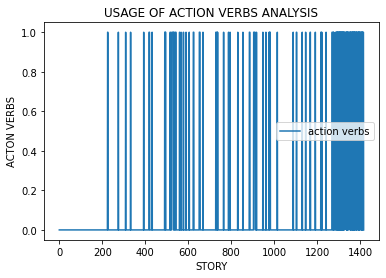

ACTION VERBS RATIO : 8.722
에세이에 표현된 다양한 감정 수: 16
문장에 표현된 감정 비율 :  57.1
['fields', 'ocean', 'from', 'well', 'off', 'street', 'trees', 'campus', 'city', 'way', 'against', 'rest', 'view', 'through', 'since', 'by', 'wall', 'over', 'keep', 'gallery', 'into', 'court', 'home', 'college', 'stand', 'window', 'in', 'museum', 'on', 'house', 'after', 'along', 'during', 'to', 'up', 'past']
SETTING RATIO :  10.01


C:\Users\cacki\anaconda3\envs\py37pytorch\lib\site-packages\ipykernel_launcher.py:700: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  0%|          | 1/971 [00:27<7:22:03, 27.34s/it]

전체 문장에서 캐릭터를 의미하는 단어나 유사어 비율 : 10.5
Degree of conflict  단어가 전체 문장(단어)에서 차지하는 비율 계산 : 0.5
감정기복비율 : 57.1
셋팅비율 계산 :  10.01
Plot Complxity : 69.73744703349844



100%|██████████| 96/96 [00:00<00:00, 1852.92it/s]


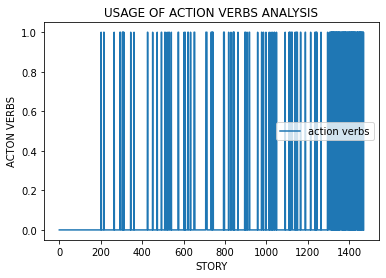

ACTION VERBS RATIO : 10.524
에세이에 표현된 다양한 감정 수: 18
문장에 표현된 감정 비율 :  64.3
['fields', 'abbey', 'from', 'well', 'vein', 'mere', 'opening', 'chapel', 'campus', 'country', 'university', 'way', 'turn', 'view', 'steps', 'until', 'before', 'through', 'since', 'by', 'head', 'sound', 'track', 'door', 'face', 'beach', 'into', 'onto', 'home', 'college', 'hold', 'in', 'upon', 'on', 'toward', 'during', 'to', 'up', 'past']
SETTING RATIO :  10.35


  0%|          | 2/971 [00:53<7:17:48, 27.11s/it]

전체 문장에서 캐릭터를 의미하는 단어나 유사어 비율 : 6.3
Degree of conflict  단어가 전체 문장(단어)에서 차지하는 비율 계산 : 0.2
감정기복비율 : 64.3
셋팅비율 계산 :  10.35
Plot Complxity : 80.22254495308658



100%|██████████| 93/93 [00:00<00:00, 3447.77it/s]


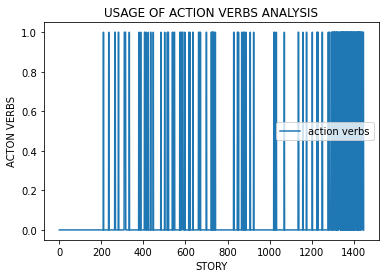

ACTION VERBS RATIO : 8.807
에세이에 표현된 다양한 감정 수: 15
문장에 표현된 감정 비율 :  53.6
['camp', 'fields', 'ocean', 'from', 'route', 'well', 'off', 'campus', 'way', 'city', 'against', 'rest', 'view', 'until', 'leg', 'before', 'through', 'since', 'by', 'over', 'sound', 'face', 'into', 'home', 'college', 'path', 'in', 'forge', 'museum', 'on', 'above', 'after', 'during', 'to', 'up', 'trail']
SETTING RATIO :  9.97


  0%|          | 3/971 [01:20<7:17:09, 27.10s/it]

전체 문장에서 캐릭터를 의미하는 단어나 유사어 비율 : 7.16
Degree of conflict  단어가 전체 문장(단어)에서 차지하는 비율 계산 : 0.2
감정기복비율 : 53.6
셋팅비율 계산 :  9.97
Plot Complxity : 66.18717828061565



100%|██████████| 82/82 [00:00<00:00, 3040.26it/s]


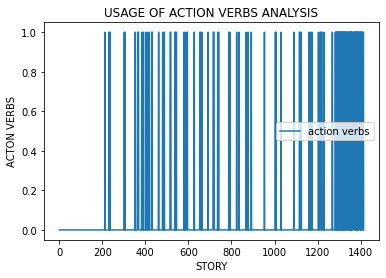

ACTION VERBS RATIO : 11.411
에세이에 표현된 다양한 감정 수: 18
문장에 표현된 감정 비율 :  64.3
['realm', 'fields', 'from', 'well', 'off', 'street', 'university', 'country', 'way', 'tube', 'view', 'before', 'through', 'by', 'wall', 'intersection', 'sound', 'into', 'onto', 'path', 'room', 'in', 'on', 'to', 'up']
SETTING RATIO :  8.74


  0%|          | 4/971 [01:44<7:01:38, 26.16s/it]

전체 문장에서 캐릭터를 의미하는 단어나 유사어 비율 : 8.8
Degree of conflict  단어가 전체 문장(단어)에서 차지하는 비율 계산 : 0.1
감정기복비율 : 64.3
셋팅비율 계산 :  8.74
Plot Complxity : 79.90038360358479



100%|██████████| 254/254 [00:00<00:00, 3488.90it/s]


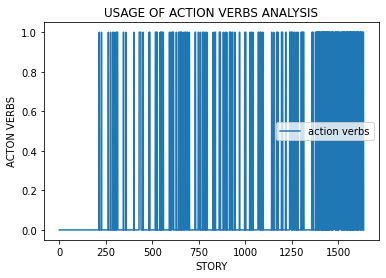

ACTION VERBS RATIO : 10.113
에세이에 표현된 다양한 감정 수: 22
문장에 표현된 감정 비율 :  78.6
['fields', 'from', 'well', 'campus', 'country', 'university', 'way', 'rest', 'turn', 'near', 'view', 'state', 'before', 'through', 'since', 'village', 'by', 'head', 'over', 'behind', 'keep', 'face', 'down', 'into', 'beach', 'home', 'college', 'town', 'in', 'upon', 'on', 'house', 'after', 'along', 'during', 'to', 'up']
SETTING RATIO :  10.14


  1%|          | 5/971 [02:15<7:24:19, 27.60s/it]

전체 문장에서 캐릭터를 의미하는 단어나 유사어 비율 : 8.86
Degree of conflict  단어가 전체 문장(단어)에서 차지하는 비율 계산 : 0.0
감정기복비율 : 78.6
셋팅비율 계산 :  10.14
Plot Complxity : 98.28442030657757



100%|██████████| 128/128 [00:00<00:00, 2984.99it/s]


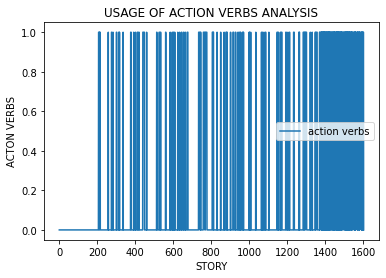

ACTION VERBS RATIO : 12.17
에세이에 표현된 다양한 감정 수: 17
문장에 표현된 감정 비율 :  60.7
['fields', 'from', 'well', 'circle', 'university', 'country', 'city', 'way', 'crossing', 'turn', 'steps', 'until', 'before', 'through', 'since', 'by', 'behind', 'keep', 'track', 'door', 'down', 'into', 'seat', 'park', 'home', 'mine', 'college', 'hold', 'window', 'in', 'museum', 'on', 'above', 'after', 'aisle', 'during', 'to', 'up', 'past', 'ford']
SETTING RATIO :  10.95


  1%|          | 6/971 [02:45<7:33:50, 28.22s/it]

전체 문장에서 캐릭터를 의미하는 단어나 유사어 비율 : 8.35
Degree of conflict  단어가 전체 문장(단어)에서 차지하는 비율 계산 : 0.7
감정기복비율 : 60.7
셋팅비율 계산 :  10.95
Plot Complxity : 74.6201495492337



100%|██████████| 92/92 [00:00<00:00, 2713.10it/s]


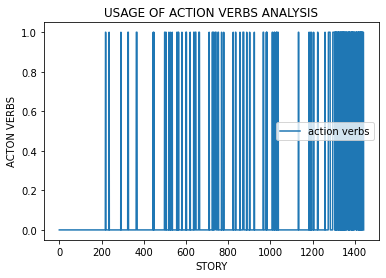

ACTION VERBS RATIO : 8.61
에세이에 표현된 다양한 감정 수: 17
문장에 표현된 감정 비율 :  60.7
['camp', 'fields', 'from', 'well', 'off', 'furnace', 'prison', 'way', 'against', 'body', 'until', 'before', 'through', 'glass', 'by', 'wall', 'over', 'giant', 'depths', 'post', 'farm', 'face', 'into', 'seat', 'college', 'room', 'forge', 'in', 'on', 'after', 'to', 'up', 'past']
SETTING RATIO :  11.5


  1%|          | 7/971 [03:13<7:31:17, 28.09s/it]

전체 문장에서 캐릭터를 의미하는 단어나 유사어 비율 : 7.05
Degree of conflict  단어가 전체 문장(단어)에서 차지하는 비율 계산 : 0.1
감정기복비율 : 60.7
셋팅비율 계산 :  11.5
Plot Complxity : 75.2748754565559



100%|██████████| 326/326 [00:00<00:00, 7105.96it/s]


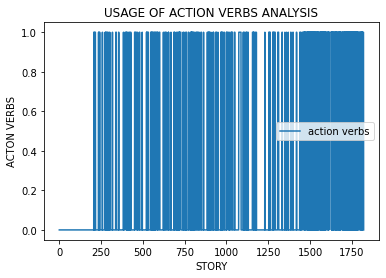

ACTION VERBS RATIO : 10.721
에세이에 표현된 다양한 감정 수: 23
문장에 표현된 감정 비율 :  82.1
['fields', 'ocean', 'wild', 'from', 'sea', 'dais', 'march', 'river', 'off', 'street', 'land', 'campus', 'bar', 'way', 'forest', 'city', 'temple', 'body', 'sanctuary', 'mouth', 'against', 'state', 'near', 'pool', 'mirror', 'until', 'before', 'through', 'since', 'remnant', 'by', 'head', 'wall', 'laboratory', 'clearing', 'over', 'behind', 'stone', 'volcano', 'post', 'void', 'farm', 'track', 'face', 'mill', 'down', 'into', 'slum', 'below', 'court', 'onto', 'home', 'corner', 'mine', 'stand', 'path', 'hold', 'pit', 'beside', 'gorge', 'in', 'upon', 'stream', 'on', 'waste', 'chest', 'house', 'along', 'during', 'to', 'up', 'past']
SETTING RATIO :  10.92


  1%|          | 8/971 [03:58<8:53:31, 33.24s/it]

전체 문장에서 캐릭터를 의미하는 단어나 유사어 비율 : 8.44
Degree of conflict  단어가 전체 문장(단어)에서 차지하는 비율 계산 : 0.1
감정기복비율 : 82.1
셋팅비율 계산 :  10.92
Plot Complxity : 102.75026557143295



100%|██████████| 23/23 [00:00<00:00, 1913.19it/s]


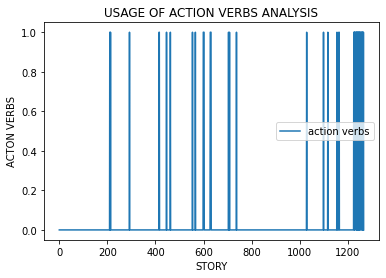

ACTION VERBS RATIO : 13.6


In [ ]:
from tqdm import tqdm

essay_results = []

for file_name_raw in tqdm(file_list): # 파일이름을 하나씩 불러와서
    file_name = path  + file_name_raw #경로를 추가하고
    with open(file_name, 'r') as json_file : #JSON파일로 파일을 열어서
        ps_input_each_data = json.load(json_file) # JSON파일로 로드한다.
        input_text = json.dumps(ps_input_each_data)
        re_each_ess = ai_plot_conf(input_text)
        essay_results.append(re_each_ess)

In [ ]:
essay_results

In [ ]:
df_r = pd.DataFrame(essay_results, columns =['plot_complexity', 'emotional_rollercoaster', 'degree_conflict'])  #e데이터프레임에 넣기
df_r

In [ ]:
setting_indicators_mean = df_r['plot_complexity'].mean()
intro_re_mean = df_r['emotional_rollercoaster'].mean()
body_re_mean = df_r['degree_conflict'].mean()


In [ ]:
setting_all_1000data_mean = [setting_indicators_mean, intro_re_mean, body_re_mean]

## 1000명 에세이 데이터 처리 결과 저장

In [ ]:

import pickle
# save
with open('1000_essay_results.pickle', 'wb') as f:
    pickle.dump(essay_results, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# load
with open('data_ai_theme.pickle', 'rb') as f:
    result_most_simWords = pickle.load(f)